# ABS Quarterly Consumer Price Index 6401

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#Remove-the-old-charts" data-toc-modified-id="Remove-the-old-charts-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Remove the old charts</a></span></li><li><span><a href="#Headline-CPI-for-Australia" data-toc-modified-id="Headline-CPI-for-Australia-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Headline CPI for Australia</a></span></li><li><span><a href="#Analytical-annual-series" data-toc-modified-id="Analytical-annual-series-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Analytical annual series</a></span></li><li><span><a href="#Inflation-by-categories-from-COVID-times-onwards" data-toc-modified-id="Inflation-by-categories-from-COVID-times-onwards-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Inflation by categories from COVID-times onwards</a></span><ul class="toc-item"><li><span><a href="#Indentify-the-main-CPI-groups-(so-we-can-ignore-them)" data-toc-modified-id="Indentify-the-main-CPI-groups-(so-we-can-ignore-them)-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Indentify the main CPI groups (so we can ignore them)</a></span></li><li><span><a href="#Bar-chart-fastest-growing-sub-groups-and-expenditure-items" data-toc-modified-id="Bar-chart-fastest-growing-sub-groups-and-expenditure-items-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Bar chart fastest growing sub-groups and expenditure items</a></span></li><li><span><a href="#Chart-all-item-growth-since-covid" data-toc-modified-id="Chart-all-item-growth-since-covid-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>Chart all-item growth since covid</a></span></li></ul></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib  
import calendar
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    plot_growth2
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '6401'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction to a DataFrame
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

Retrieving zip-file from cache ./ABS_CACHE/_statistics_economy_price-indexes-and-inflation_consumer-price-index-australia_sep-quarter-2022_All-Time-Series-Spreadsheets.zip ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

### Remove the old charts
We do this because the top expenditue item charts are uniquely named

In [5]:
for filename in pathlib.Path(CHART_DIR).glob("*.png"):
    filename.unlink()

### Headline CPI for Australia

In [6]:
table = '2'
data = abs_dict[table]
series_type = 'Original'
title = 'All groups CPI ;  Australia'
quarterly_desc = f'Percentage Change from Previous Period ;  {title} ;'
annual_desc = f'Percentage Change from Corresponding Quarter of Previous Year ;  {title} ;'

identifiers = []
for description in (annual_desc, quarterly_desc):
    ident, units = get_identifier(meta, description, series_type, table)
    identifiers.append(ident)

# plot
for plot_from, plot_tag in zip(plot_times, plot_tags):
    plot_growth2(data[identifiers[0]], data[identifiers[1]], 
                 title.replace(" ; ", ""), 
                 plot_from, plot_tag, CHART_DIR,
                 rfooter=f'{source} {table}',
                 lfooter=f'{series_type.capitalize()} series',
                 ppy=4, # four periods per year
                 #show=True
                 )

In [7]:
identifiers

['A2325847F', 'A2325850V']

In [8]:
# Latest annual
data[identifiers[0]].tail()

Series ID
2021-09-01    3.0
2021-12-01    3.5
2022-03-01    5.1
2022-06-01    6.1
2022-09-01    7.3
Name: A2325847F, dtype: float64

In [9]:
# Latest qty
data[identifiers[1]].tail() #.rolling(window=4).sum().tail(), 

Series ID
2021-09-01    0.8
2021-12-01    1.3
2022-03-01    2.1
2022-06-01    1.8
2022-09-01    1.8
Name: A2325850V, dtype: float64

In [10]:
# stationary
round(data[identifiers[1]][-3:].sum() + data[identifiers[1]][-1], 1)

7.5

In [11]:
# 2.5 percent last quarter
round(data[identifiers[1]][-3:].sum() + 2.5, 1)

8.2

### Analytical annual series

In [12]:
table = '8'
data = abs_dict[table]
stem = 'Percentage Change from Corresponding Quarter of Previous Year ;  '
post = ' ;  Australia ;'
groups = [
    ['Tradables', 'Non-tradables'],
    ['Original', 'Seasonally Adjusted'],
    ['Goods', 'Services'],
    ['Trimmed Mean', 'Weighted Median'],
]

# manage long/ugly names
replacements = {
    'Goods': 'All groups, goods component',
    'Services': 'All groups, services component',
    'Original': 'All groups CPI',
    'Seasonally Adjusted': 'All groups CPI, seasonally adjusted',
}

for dataset in groups:
    idents = []
    for title in dataset:
        if title in replacements:
            title = replacements[title]
        description = f'{stem}{title}{post}'
        series_type = ('Seasonally Adjusted' if 'season' in title 
                            or 'Trimmed' in title
                            or 'Weighted' in title
                       else 'Original'
                      )
        ident, units = get_identifier(meta, description, series_type, table)
        idents.append(ident)
        
    for start, tag in zip(plot_times, plot_tags):
        df = data[data.index >= start] if start else data
        pair = df[idents]
        pair = pair.dropna(how='all', axis=0)
        ax = pair.plot(lw=2, color=['blue', 'darkorange'])
        ax.legend(dataset, loc='best')
        finalise_plot(
            ax, f'CPI Australia: {", ".join(dataset)}', 
            units, tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter='Per cent change from same quarter in previous year',
            #show=True,
        )

### Inflation by categories from COVID-times onwards

#### Indentify the main CPI groups (so we can ignore them)

In [13]:
# Use table 4 to identify the main CPI groups - which we will exclude
groups = meta[meta.Table == '4'].copy()
groups = (
    groups[groups['Data Item Description']
           .str.contains('Index Numbers ;  ')]
    ['Series ID']
)
groups.values

array(['A2325891R', 'A2326116V', 'A2325936J', 'A2325981V', 'A2326026R',
       'A2331111C', 'A2326071A', 'A2331201J', 'A2331246L', 'A2331426W',
       'A2332596F', 'A2325846C'], dtype=object)

In [14]:
# Capture the detailed index numbers from table 7
table = '7'
data = abs_dict[table]
FROM = pd.Timestamp('2019-12-01')
wanted = meta[(meta.Table == table) 
              & (meta['Data Item Description'].str.contains('Index Numbers '))].copy()

# remove all-groups CPI
wanted = wanted[wanted['Data Item Description'] != 'Index Numbers ; All groups CPI ; Australia ;']

# remove CPI groups
wanted = wanted[~wanted['Series ID'].isin(groups)]

# Remove duplicates (because the sub group is the same as the expenditure class)
wanted = wanted.drop_duplicates(subset='Data Item Description', keep='last')

mapper = (
    wanted['Data Item Description']
    .copy()
    .str.replace('Index Numbers ;  ', '')
    .str.replace(' ;  Australia ;', '')
)
mapper.index = wanted['Series ID']

#### Bar chart fastest growing sub-groups and expenditure items

In [15]:
KEEP_TOP = 20

def get_growers(periods, keep):
    return ((
        (
            data[wanted['Series ID']].iloc[-1] 
             / data[wanted['Series ID']].iloc[-1 - periods] * 100) 
            -100
        )
        .sort_values(ascending=False)[:keep]
    )

(9, 6)


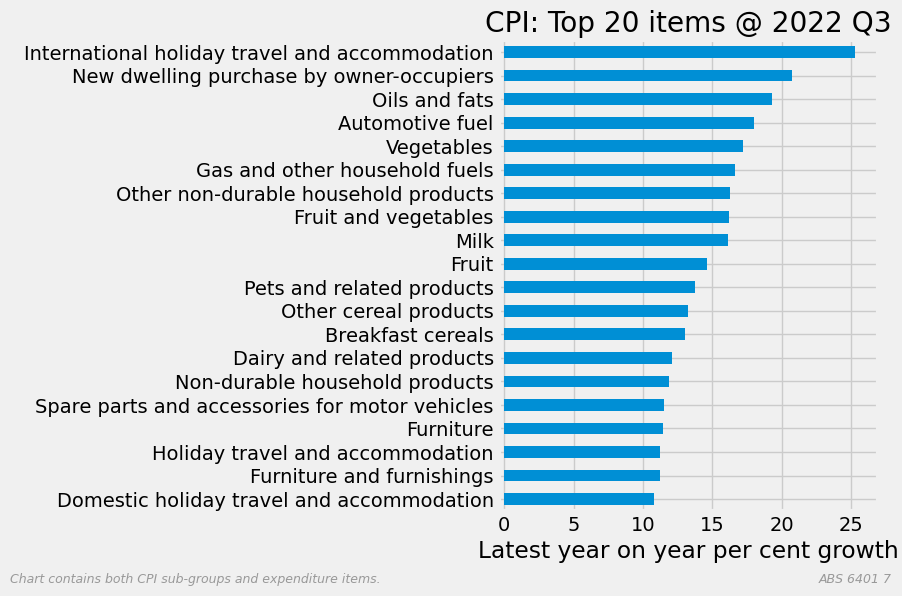

In [16]:
top_y_growers = get_growers(4, KEEP_TOP)
top_y_growers.index = top_y_growers.index.map(mapper)                                  
                                            
ax = top_y_growers[::-1].plot.barh()
quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")
finalise_plot(
    ax, 
    f'CPI: Top {KEEP_TOP} items @ {quarter}', 
    '', 
    'y', # tag
    CHART_DIR,
    rfooter=f'{source} {table}',
    xlabel='Latest year on year per cent growth',
    figsize=(9, 6), 
    lfooter='Chart contains both CPI sub-groups and expenditure items. ',
    show=True,
)

(9, 6)


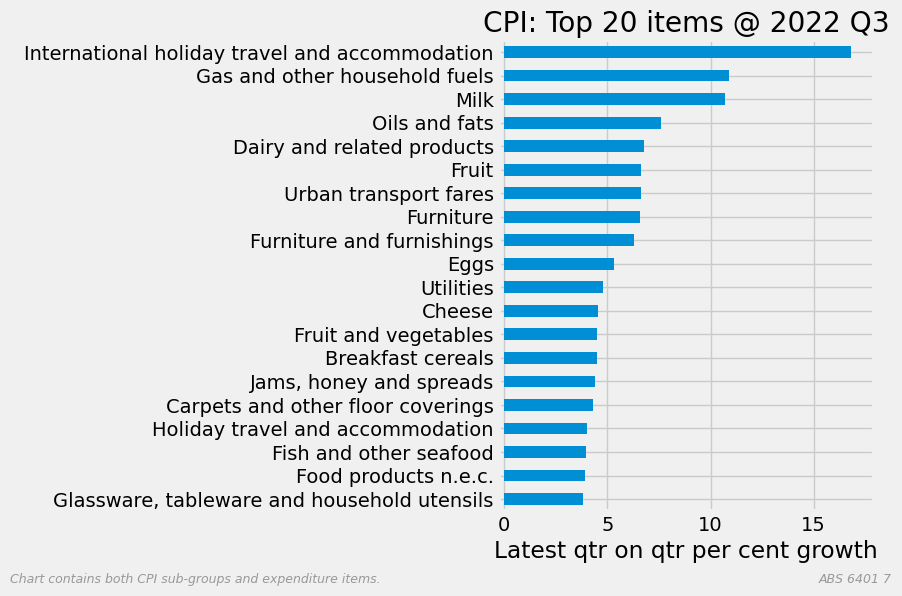

In [17]:
top_q_growers = get_growers(1, KEEP_TOP)
top_q_growers.index = top_q_growers.index.map(mapper)                                  
                                            
ax = top_q_growers[::-1].plot.barh()
quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")
finalise_plot(
    ax, 
    f'CPI: Top {KEEP_TOP} items @ {quarter}', 
    '', 
    'q', # tag
    CHART_DIR,
    rfooter=f'{source} {table}',
    xlabel='Latest qtr on qtr per cent growth',
    figsize=(9, 6), 
    lfooter='Chart contains both CPI sub-groups and expenditure items. ',
    show=True,
)

#### Chart all-item growth since covid

In [18]:
# get the data, and rebase the index numbers
selected = data[wanted['Series ID']]
selected = selected[selected.index >= FROM]
selected = selected.div(selected.iloc[0]) * 100 

# rename the columns
replacements = (
    meta[meta['Series ID'].isin(selected.columns.values)]
    .drop_duplicates('Series ID', keep='first')['Data Item Description']
    .str.replace('Index Numbers ;  ', '')
    .str.replace(' ;  Australia ;', '')
    .values
)
renamer = {orig: replace for orig, replace in zip(selected.columns, replacements)}
selected = selected.rename(columns=renamer)

In [19]:
def _highlight(ax, df, date, number, high, ha):
    print(date, number, high)
    date = pd.Timestamp(date)
    illuminate = df.loc[date]
    illuminate = illuminate.dropna().sort_values(ascending=high)[-number:]
    print(illuminate)
    names = []
    va = 'bottom' if high else 'top'
    for name, value in illuminate.items():
        ax.text(date, value, name, va=va, ha=ha)
        names.append(name)
    print(names)
    
highlights = [
    ['2020-06-01', 3, False, 'center'], #
    ['2020-12-01', 2, True, 'center'],
    ['2020-12-01', 2, False, 'center'],
    #['2021-06-01', 3, True, 'center'],
    #['2021-09-01', 1, False, 'center'],
    ['2022-06-01', 1, True, 'right'],
    ['2022-06-01', 2, False, 'right'],
]

def highlight(ax, df):
    for date, number, high, ha in highlights:
        _highlight(ax, df, date, number, high, ha)

2020-06-01 3 False
Automotive fuel                    75.800377
Domestic and household services    60.445469
Child care                          5.023133
Name: 2020-06-01 00:00:00, dtype: float64
['Automotive fuel', 'Domestic and household services', 'Child care']
2020-12-01 2 True
Major household appliances    109.915612
Tobacco                       119.856278
Name: 2020-12-01 00:00:00, dtype: float64
['Major household appliances', 'Tobacco']
2020-12-01 2 False
Electricity        90.775988
Automotive fuel    83.333333
Name: 2020-12-01 00:00:00, dtype: float64
['Electricity', 'Automotive fuel']
2022-06-01 1 True
Automotive fuel    127.495292
Name: 2022-06-01 00:00:00, dtype: float64
['Automotive fuel']
2022-06-01 2 False
Deposit and loan facilities (direct charges)    96.060606
Electricity                                     93.118594
Name: 2022-06-01 00:00:00, dtype: float64
['Deposit and loan facilities (direct charges)', 'Electricity']


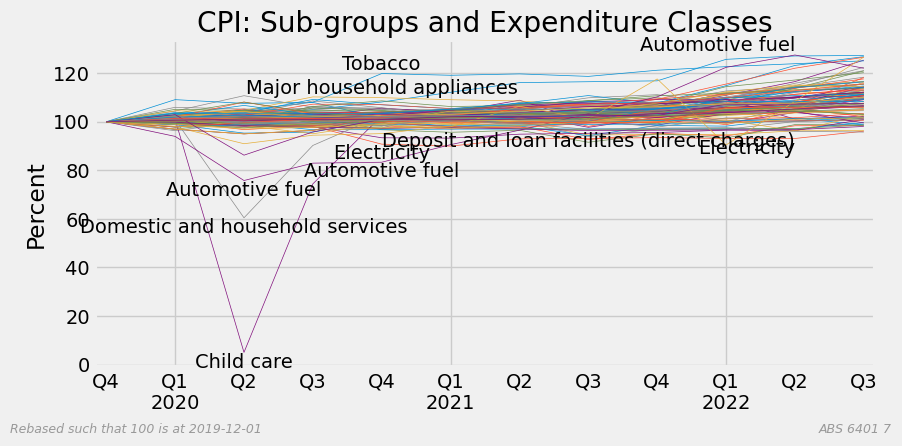

In [20]:
ax = selected.plot(lw=0.5)
highlight(ax, selected)
ax.legend().remove()
finalise_plot(ax, 'CPI: Sub-groups and Expenditure Classes', 
              units, '', CHART_DIR,
              rfooter=f'{source} {table}',
              lfooter=f'Rebased such that 100 is at {FROM.date()}',
              show=True,
)

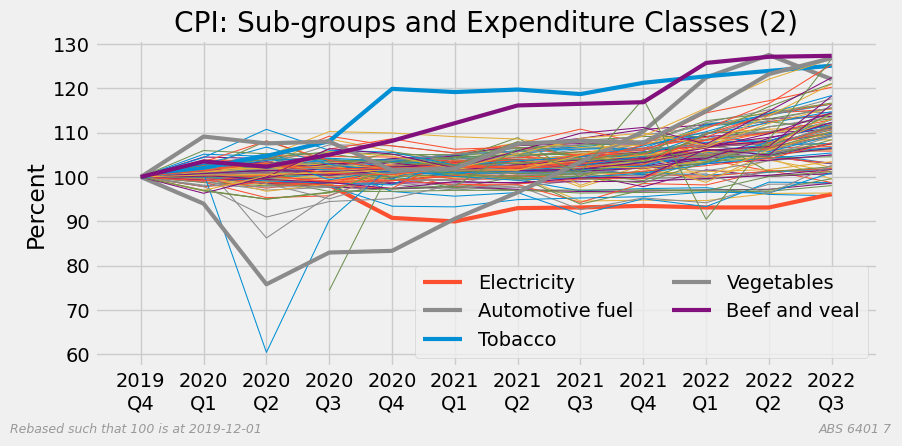

In [21]:
# second try - focus on key items
MINIMUM_PLOT = 59
if MINIMUM_PLOT:
    selection = selected.where(selected>=MINIMUM_PLOT, other=np.nan).copy()
selection.index = [str(x).replace('Q', '\nQ') 
                    for x in selection.index.to_period()]
selection = selection.sort_values(axis=1, by=selection.index[-1])
    
key = ['Electricity', 'Automotive fuel', 'Beef and veal', 
       'Vegetables', 'Tobacco',
       #'Gas and other household fuels', 
       #'Domestic holiday travel and accommodation',
       #'International holiday travel and accommodation',
      ]

fig, ax = plt.subplots()
for column in selection:
    lw, label = (3, column) if column in key else (0.75, None)
    ax.plot(selection.index, selection[column], lw=lw, label=label)
ax.legend(loc='best', ncol=2)
finalise_plot(ax, 'CPI: Sub-groups and Expenditure Classes (2)', 
              units, '', CHART_DIR,
              rfooter=f'{source} {table}',
              lfooter=f'Rebased such that 100 is at {FROM.date()}',
              show=True,
)

## Finished

In [22]:
print('Finished')

Finished
